### File Imports

In [1]:
import requests
import os 
import datetime

import vertexai
from vertexai.generative_models import GenerativeModel, ChatSession

project_id = "uva-event-oracle"
location = "us-central1"
vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.5-pro-preview-0409")

def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    response = chat.send_message(prompt, stream=False)
    return response.text

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open("sites.json") as f:
    sites = json.load(f)
f.close()
js_sites = {}
for i,site in enumerate(sites):
    if site["js"] == True:
        js_sites[i] = site["target"]
print(js_sites)

{1: 'trumba.spud.5.iframe', 4: 's-lc-mc-evt', 6: 'em-card_event-text', 7: 'card__detail', 9: 'spud913f6613-59b3-4547-ba85-97693a7c9dbb.iframe'}


In [3]:
# manual div class keywords
keywords = ["event", "content", "detail", "card", "views","location","time", "date", "notes", "evt"]

# previous 10 years
years = [str(i) for i in range(2010, datetime.datetime.now().year)]

# all monnth in title case
old_months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
index_of_month = old_months.index(datetime.datetime.now().strftime("%B"))
old_months = old_months[:index_of_month]

# date fmts
date_fmts = [
    "%b %d, %Y",    # MMM dd, yyyy (e.g., Apr 12, 2024)
    "%B %d, %Y",    # MMMM dd, yyyy (e.g., April 12, 2024)
    "%b %d",        # M dd (e.g., Apr 12)
    "%B %d",        # M dd (e.g., April 12)
    "%b %Y",        # M yyyy (e.g., Apr 2024)
    "%B %Y",        # M yyyy (e.g., April 2024)
]

### Main Functions


In [4]:

# Custom HTML Parsing as solution vs. LLM Text Extraction w/ HTML Filtering
import bs4
import requests
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

"""
1. Retrieve HTML from a site
1.1 Retrieve HTML from a site using Selenium
2. Extract event text from HTML
2.5 Preprocess Event Text
3. Store event text in a file
4. Convert to JSON or CSV via LLM
5. Store in a database

"""

#* 1 - Retrieve HTML from a site
def get_html(site):
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
        }
        response = requests.get(site, headers=headers)
    except:
        print('Failed to retrieve html from site')
        return None
    
    if response is None:
        print('Failed to retrieve html from site')
        return None
    return response.text

# 1.1 - Retrieve HTML from a site using Selenium
def get_html_selenium(site, id, site_dict):
    driver = webdriver.Chrome()
    driver.get(site)
    time.sleep(5)
    element = None
    target_element = site_dict[id]
    print(f"Target Element: {target_element}")
    button_element = "//a[text()='WEEK' and @role='button']"
    iframes = driver.find_elements("id",'trumba.spud.3.iframe')
    button_iframe = "trumba.spud.3.iframe"
    
    if len(iframes) > 0:
        print("Found IFRAME")
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, button_iframe)))
        print("Found IFRAME")
        driver.switch_to.frame(button_iframe)
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.XPATH, button_element)))
        print("Found Button")
        element.click()
        time.sleep(2)
        driver.switch_to.default_content()
    
    if ".iframe" in target_element:
        element = WebDriverWait(driver, 30).until(
            EC.presence_of_element_located((By.ID, target_element))
        )
        driver.switch_to.frame(target_element)
        print("Found IFRAME")
        time.sleep(5)
        
    else:
        print("Waiting for Target Element")
        try:
            element = WebDriverWait(driver, 30).until(
                EC.presence_of_element_located((By.CLASS_NAME, target_element))
            )
        except:
            print("Failed to find target element, still saving the html")

    html = driver.page_source
    driver.quit()
    return html

#! --------------------------------------------------------------------------------------------

#* 2 - Extract event text from HTML
def extract_event_text(soup):
    all_divs = soup.find_all('div')
    lowercase_all_divs_classes(all_divs)
    event_text = extract_text_from_event_divs(all_divs)
    event_text = filter_event_text(event_text)
    event_text = retrieve_event_patterns(event_text)
    return event_text

def extract_span_text(soup):
    all_spans = soup.find_all('span')
    lowercase_all_divs_classes(all_spans)
    event_text = extract_text_from_event_divs(all_spans)
    return event_text

# 2.5 - Preprocess Event Text
def lowercase_all_divs_classes(divs):
    for div in divs:
        if div.has_attr('class'):
            div['class'] = [x.lower() for x in div['class']]

# heuristic filter for after line extraction
# if the 4 lines before and after don't have numbers, it is not an event
def filter_event_text(event_text):
    indexes_to_remove = []

    for index, line in enumerate(event_text):
        if index < 4 or index > len(event_text) - 5:
            continue
        
        if any(char.isdigit() for char in line):
            continue
        
        count = 0
        for i in range(5):
            if any(char.isdigit() for char in event_text[index - i]) or any(char.isdigit() for char in event_text[index + i]):
                break
            count += 1
        if count == 3:
            indexes_to_remove.append(index)
            
    print(indexes_to_remove)
    return [event_text[i] for i in range(len(event_text)) if i not in indexes_to_remove]

# heuristic filter after event number filter
# iterate through the lines add a line only if it is not a duplicate

def retrieve_event_patterns(event_text):
    events = []
    for index, line in enumerate(event_text):
        if line not in events:
            events.append(line)
        
        # checks future events to determine if it is a duplicate
        if any(char.isdigit() for char in line):
            if index < len(event_text) - 1:
                if event_text[index + 1] not in events:
                    events.append(event_text[index + 1])
    return events
    

def extract_text_from_event_divs(event_divs):
    event_text = []
    for div in event_divs:
        text = div.get_text()
        text = [x for x in text.split('\n') if x != '']
        for line in text:
            if is_old_event(line):
                continue
            while '\n' in line:
                line = line.replace('\n', ' ')
            event_text.append(line + '\n')
    return event_text

def is_old_event(line):
    if any(year in line for year in years):
        return True
    elif any(month in line for month in old_months):
        return True
    return False

def remove_duplicates(event_text):
    return list(set(event_text))

#! --------------------------------------------------------------------------------------------


#* 3 - Store event text in a file
def write_event_text(event_text, filename):
    event_text = [x.encode('ascii', 'ignore').decode('ascii') for x in event_text]
    folder = "extracted_txt"
    file_path = folder + "/" + filename
    if os.path.exists(folder) == False:
        os.mkdir(folder)
    with open(file_path, 'w') as f:
        for event in event_text:
            if len(event) > 0 or event != ' ':
                f.write(event)
    f.close()
    return 0

def test_write_event_text(event_text, filename):
    event_text = [x.encode('ascii', 'ignore').decode('ascii') for x in event_text]
    print(f"After Removing Duplicates {len(event_text)}")
    folder = "test_extractions_txt"
    file_path = folder + "/" + filename
    with open(file_path, 'w') as f:
        for event in event_text:
            if len(event) > 0 or event != ' ':
                f.write(event)
    f.close()
    return 0
#! --------------------------------------------------------------------------------------------

#* 4 - Convert to JSON or CSV via LLM
def convert_to_json(site_index):
    input_text = """ 
    Convert this text to JSON for events with this schema:
    - Title: The name of the event 
    - Start Time: Has to be 1 value
    - End Time: Has to be 1 value
    - Date: Month, Day of the event 
    - Location: Where the event takes place 
    
    Time Numbers close together like 1600 should be converted to have a colon separated like 16:00
    
    """
    filename = f'site_{site_index}.txt'
    with open(f'extracted_txt/{filename}') as f:
        site_text = f.read()
    input_text += site_text
    try:
        chat = model.start_chat()
        response = get_chat_response(chat, input_text)
    except:
        print("Failed to convert to JSON")
        response = "[]"
    
    output = response
    
    #! weird things to filter json response
    while "`" in output:
        output = output.replace("`", "")
    output = output.replace("JSON", "")
    output = output.replace("json", "")
    if os.path.exists(f'event_jsons/') == False:
        os.mkdir('event_jsons')
    with open(f'event_jsons/site_{site_index}.json', 'w') as f:
        f.write(output)
    f.close()
    
    return 0

#! --------------------------------------------------------------------------------------------

#* 5 - Read JSON and store in a database
def read_json(site_index):
    with open(f'event_jsons/site_{site_index}.json') as f:
        event_json = f.read()
    f.close()
    return event_json

# X - Store as a CSV for now

#! --------------------------------------------------------------------------------------------


def single_site(site):
    html = get_html(site)
    print(html)
    soup = bs4.BeautifulSoup(html, 'html.parser')
    event_text = extract_event_text(soup)
    write_event_text(event_text, 'site.txt')
    print(len(event_text))
    print(event_text)
    return 0

def single_site_js(site, id, site_dict):
    html = get_html_selenium(site, id, site_dict)
    print(html)
    soup = bs4.BeautifulSoup(html, 'html.parser')
    event_text = extract_event_text(soup)
    write_event_text(event_text, 'site.txt')
    convert_to_json(1)  
    print(len(event_text))
    print(event_text)
    return 0

def process_sites():
    for i, site_object in enumerate(sites):
        print("*" * 20)
        site = site_object["site"]
        print(f"Processing site {site}")

        if i in js_sites:
            html = get_html_selenium(site, i, js_sites)
        else:
            html = get_html(site)

        if html is None:
            print(f"Failed to retrieve html from site {i}")
            continue
        soup = bs4.BeautifulSoup(html, 'html.parser')
        event_text = extract_event_text(soup)
        write_event_text(event_text, f'site_{i}.txt')
        convert_to_json(i)

        print(f"Finished processing site {i}")
        print("*" * 20)
        # # gemini pro free can only process 2 requests per minute
        # time.sleep(30)
    return 0

In [5]:
process_sites()

********************
Processing site https://scholarslab.lib.virginia.edu/events/
[72, 78, 79, 85, 95, 102, 121]
Finished processing site 0
********************
********************
Processing site https://www.virginia.edu/calendar
Target Element: trumba.spud.5.iframe
Found IFRAME
Found IFRAME
Found Button
Found IFRAME
[]
Finished processing site 1
********************
********************
Processing site https://education.virginia.edu/events
[60, 68, 69, 76, 79, 85, 86, 93, 96, 108, 109, 122, 126, 141, 142, 157, 158, 170, 174, 186, 191, 203, 207, 222, 224, 236, 256, 263, 281, 287, 346, 354, 355, 362, 365, 371, 372, 379, 382, 394, 395, 408, 412, 427, 428, 443, 444, 456, 460, 472, 477, 489, 493, 508, 510, 522, 542, 549, 567, 573, 744, 752, 753, 760, 763, 769, 770, 777, 780, 792, 793, 806, 810, 825, 826, 841, 842, 854, 858, 870, 875, 887, 891, 906, 908, 920, 936, 944, 945, 952, 955, 961, 962, 969, 972, 984, 985, 998, 1002, 1017, 1018, 1033, 1034, 1046, 1050, 1062, 1067, 1079, 1083, 1098,

0

### Date Conversion

In [6]:
def update_year(value):
    if pd.isna(value):
        return value
    return value.replace(year=2024)

def convert_to_datetime(value):
    new_value = value
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    while "." in new_value:
        new_value = new_value.replace('.', '')
    for fmt in ('%I:%M%p', '%I:%M %p', '%I%p', '%I %p'):
        try:
            return pd.to_datetime(new_value, format=fmt)
        except ValueError:
            pass
    return new_value

def convert_to_date(value):
    new_value = value
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    while "." in new_value:
        new_value = new_value.replace('.', '')
    for fmt in date_fmts:
        try:
            return pd.to_datetime(new_value, format=fmt)
        except ValueError:
            pass

def edit_time(value):
    if pd.isna(value) or isinstance(value, pd.Timestamp):
        return value
    try:
        times = str.split(value, ':')
        hour = int(times[0])
        # if times[1] is > 10 chars
        if len(times[1]) > 4:
            print(f"Failed to convert time {value}")
            return None
        if hour > 12:
            hour -= 12
            return str(hour) + ':' + times[1] + ' pm'
        if hour < 10:
            return value + ' pm'
        else:
            return value + ' am'
    except:
        print(f"Failed to convert time {value}")
        return None

In [7]:
all_events = []
event_dfs = []
nan_dfs = []
discard_dfs = []

with open('sites.json') as f:
    site_dict = json.load(f)
f.close()

for id, site_meta in enumerate(site_dict):
    file = f'site_{id}.json'
    try:
        with open(f'event_jsons/{file}') as f:
            text = json.load(f)
        f.close()
    except:
        continue
    
    if len(text) == 0:
        continue
    print(f"{id}. Processing site {site_meta['site']}")
    print(f"Number of events: {len(text)}")
    for event in text:
        event["Department"] = site_meta["department"]
        event["Site"] = site_meta["site"]
        all_events.append(event)
    
    #! more weird processing logic
    df = pd.DataFrame(text)
    print(df.columns)
    nan_df = df[df["Date"].isna()]
    df["Date"] = df["Date"].apply(convert_to_date).apply(update_year)
    nan_df = pd.concat([nan_df, df[df["Date"].isna()]])
    
    discard_df = df[df["Date"] < datetime.datetime.now()]
    df = df[df["Date"] >= datetime.datetime.now()]

    df["Start Time"] = df["Start Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)
    df["End Time"] = df["End Time"].apply(convert_to_datetime).apply(edit_time).apply(convert_to_datetime)
    df.drop_duplicates(subset=['Title'], inplace=True)

    event_dfs.append(df)
    nan_dfs.append(nan_df)
    discard_dfs.append(discard_df)

1. Processing site https://www.virginia.edu/calendar
Number of events: 8
Index(['Title', 'Start Time', 'End Time', 'Date', 'Location', 'Department',
       'Site'],
      dtype='object')
2. Processing site https://education.virginia.edu/events
Number of events: 8
Index(['Title', 'Start Time', 'End Time', 'Date', 'Location', 'Department',
       'Site'],
      dtype='object')
3. Processing site https://global.virginia.edu/events
Number of events: 9
Index(['Title', 'Start Time', 'End Time', 'Date', 'Location', 'Department',
       'Site'],
      dtype='object')
5. Processing site https://engineering.virginia.edu/news-events/events
Number of events: 5
Index(['Title', 'Start Time', 'End Time', 'Date', 'Location', 'Department',
       'Site'],
      dtype='object')
6. Processing site https://commcal.mcintire.virginia.edu/
Number of events: 15
Index(['Title', 'Start Time', 'End Time', 'Date', 'Location', 'Department',
       'Site'],
      dtype='object')
7. Processing site https://www.arch.

In [8]:
# List Potential N/A Values in a list
na_words = ["None", "N/A"]
all_events_df = pd.concat(event_dfs)
for na_word in na_words:
    print(f"Replacing {na_word}")
    all_events_df.replace(na_word, pd.NA, inplace=True)
all_events_df.reset_index(drop=True, inplace=True)



Replacing None
Replacing N/A


In [9]:
# department = University of Virginia Library
all_events_df

,Title,Start Time,End Time,Date,Location,Department,Site
0,Fall Online Welcome for New Graduate Students,1900-01-01 19:00:00,1900-01-01 20:00:00,2024-08-21,None,School of Education and Human Development,https://education.virginia.edu/events
1,Fall In-Person Graduate Orientation for New St...,1900-01-01 09:30:00,1900-01-01 14:30:00,2024-08-23,None,School of Education and Human Development,https://education.virginia.edu/events
2,Fall Welcome for All EHD Undergraduates,1900-01-01 13:00:00,NaT,2024-08-26,None,School of Education and Human Development,https://education.virginia.edu/events
3,BIPOC/LGBTQIA+ Welcome Dinner,1900-01-01 17:00:00,1900-01-01 18:30:00,2024-09-10,Holloway Hall,School of Education and Human Development,https://education.virginia.edu/events
4,M.Ed. in Communication Sciences & Disorders In...,1900-01-01 09:00:00,1900-01-01 10:30:00,2024-09-13,"Sheila C. Johnson Center, 417 Emmet Street Sou...",School of Education and Human Development,https://education.virginia.edu/events
...,...,...,...,...,...,...,...
68,RED Lecture with Dana Lloyd,1900-01-01 17:00:00,1900-01-01 19:00:00,2024-09-19,TBA,Religious Studies,https://religiousstudies.as.virginia.edu/events
69,Rupa Pillai Lecture on Asian American Religiou...,NaT,NaT,2024-11-07,None,Religious Studies,https://religiousstudies.as.virginia.edu/events
70,Cynefin Inaugral Exhibition and Gallery CLOSES,NaT,NaT,2024-08-09,"13 Lefkosias Street, 11252 Athens Attica",Art,https://art.as.virginia.edu/upcoming-events
71,UVA Arts Welcome Picnic,1900-01-01 18:00:00,1900-01-01 20:00:00,2024-09-08,Betsy and John Casteen Arts Grounds,Art,https://art.as.virginia.edu/upcoming-events


In [10]:
all_events_time_nan_df = all_events_df[all_events_df["Start Time"].isna() & all_events_df["End Time"].isna()]
nan_df = pd.concat(nan_dfs)
nan_df = pd.concat([nan_df, all_events_time_nan_df])
nan_df.reset_index(drop=True, inplace=True)

discard_df = pd.concat(discard_dfs)
discard_df.reset_index(drop=True, inplace=True)

# drop from all_events_df if start and end time are both null and only if both
all_events_df = all_events_df[~all_events_df.index.isin(all_events_time_nan_df.index)]


print(f'Total Events {nan_df.shape[0] + all_events_df.shape[0]}')
print(f'Discarded Events {discard_df.shape[0]}')

Total Events 376
Discarded Events 11


In [11]:
#! Guessing times if the opposite is NaN

missing_end_time_rows = all_events_df["End Time"].isna()
new_end_time_values = all_events_df.loc[missing_end_time_rows, "Start Time"] - datetime.timedelta(hours=1)
all_events_df.loc[missing_end_time_rows, "End Time"] = new_end_time_values

missing_start_time_rows = all_events_df["Start Time"].isna()
new_start_time_values = all_events_df.loc[missing_start_time_rows, "End Time"] - datetime.timedelta(hours=1)
all_events_df.loc[missing_start_time_rows, "Start Time"] = new_start_time_values

# set both start and etime column dtypes to dt
all_events_df["Start Time"] = pd.to_datetime(all_events_df["Start Time"])
all_events_df["End Time"] = pd.to_datetime(all_events_df["End Time"])

all_events_df["Start Time"] = all_events_df["Start Time"].dt.strftime('%I:%M %p')
all_events_df["End Time"] = all_events_df["End Time"].dt.strftime('%I:%M %p')

C:\Users\commo\AppData\Local\Temp\ipykernel_24196\2676760389.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_events_df["Start Time"] = pd.to_datetime(all_events_df["Start Time"])
C:\Users\commo\AppData\Local\Temp\ipykernel_24196\2676760389.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_events_df["End Time"] = pd.to_datetime(all_events_df["End Time"])
C:\Users\commo\AppData\Local\Temp\ipykernel_24196\2676760389.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

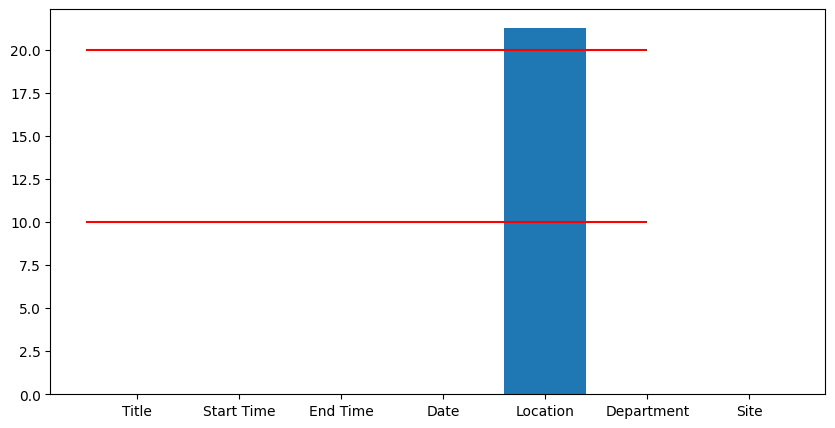

In [12]:
# sum isna
isna = all_events_df.isna().sum()
rows = all_events_df.shape[0]
isna_percent = isna / rows * 100
plt.figure(figsize=(10, 5))
plt.bar(isna_percent.index, isna_percent)
plt.hlines(20, -.5, 5, colors='r')
plt.hlines(10, -.5, 5, colors='r')

In [13]:
all_events_df

,Title,Start Time,End Time,Date,Location,Department,Site
0,Fall Online Welcome for New Graduate Students,07:00 PM,08:00 PM,2024-08-21,None,School of Education and Human Development,https://education.virginia.edu/events
1,Fall In-Person Graduate Orientation for New St...,09:30 AM,02:30 PM,2024-08-23,None,School of Education and Human Development,https://education.virginia.edu/events
2,Fall Welcome for All EHD Undergraduates,01:00 PM,12:00 PM,2024-08-26,None,School of Education and Human Development,https://education.virginia.edu/events
3,BIPOC/LGBTQIA+ Welcome Dinner,05:00 PM,06:30 PM,2024-09-10,Holloway Hall,School of Education and Human Development,https://education.virginia.edu/events
4,M.Ed. in Communication Sciences & Disorders In...,09:00 AM,10:30 AM,2024-09-13,"Sheila C. Johnson Center, 417 Emmet Street Sou...",School of Education and Human Development,https://education.virginia.edu/events
5,M.Ed. in Communication Sciences & Disorders Vi...,10:00 AM,10:45 AM,2024-09-27,None,School of Education and Human Development,https://education.virginia.edu/events
9,Yongle Dadian: An Emperors Encyclopedia The S...,05:30 PM,04:30 PM,2024-07-29,The Edgar Shannon Library,UVA Global,https://global.virginia.edu/events
10,Connecting the Dots: From Education Abroad to ...,11:00 AM,10:00 AM,2024-08-30,TBD,UVA Global,https://global.virginia.edu/events
11,Welcome Back CGHE Scholars,12:15 AM,11:15 PM,2024-09-04,Center for Global Health Equity,UVA Global,https://global.virginia.edu/events
12,Fall Education Abroad Fair,11:00 AM,10:00 AM,2024-09-10,Newcomb Hall Ballroom,UVA Global,https://global.virginia.edu/events


In [14]:
nan_with_date_df = all_events_df[all_events_df["Date"].isna()]

In [15]:
all_events_df.reset_index(drop=True, inplace=True)
nan_df.reset_index(drop=True, inplace=True)
nan_with_date_df.reset_index(drop=True, inplace=True)

all_events_df.to_csv('allevents_csv/all_events.csv', index=False)
nan_df.to_csv('allevents_csv/nan_events.csv', index=False)
nan_with_date_df.to_csv('allevents_csv/nan_with_date_events.csv', index=False)

### LLM Playground

In [16]:

# TODO(developer): Update and un-comment below lines
project_id = "uva-event-oracle"
location = "us-central1"
vertexai.init(project=project_id, location=location)
model = GenerativeModel("gemini-1.0-pro")
chat = model.start_chat()

def get_chat_response(chat: ChatSession, prompt: str) -> str:
    text_response = []
    responses = chat.send_message(prompt, stream=True)
    for chunk in responses:
        text_response.append(chunk.text)
    return "".join(text_response)

prompt = "Hello."
print(get_chat_response(chat, prompt))

prompt = "What are all the colors in a rainbow?"
print(get_chat_response(chat, prompt))

prompt = "Why does it appear when it rains?"
print(get_chat_response(chat, prompt))

Hello! 👋 I'm happy to help in any way I can. What would you like to talk about today? 

I can answer your questions in an informative way, even if they are open ended, challenging, or strange.  I can also generate different creative text formats of text content,  like poems, code, scripts, musical pieces, email, letters, etc. I will try my best to fulfill all your requirements.
A rainbow has seven colors:

1. **Red** 🟥
2. **Orange** 🟧
3. **Yellow** 🟨
4. **Green** 🟩
5. **Blue** 🟦
6. **Indigo** indigo
7. **Violet** 🟪 

These colors appear in a specific order, with red at the top and violet at the bottom. This order is determined by the way light interacts with water droplets in the atmosphere. 

Would you like to know more about rainbows, or something else entirely? 

## How Rainbows Form

Rainbows are a beautiful optical phenomenon caused by the interaction of sunlight and water droplets in the atmosphere. Here's a breakdown of the steps involved:

**1. Sunlight enters a raindrop:**

Wh

In [17]:
input_text = """ 
    Convert this text to JSON for events with this schema:
    Event:
    - Title: The name of the event 
    - Start Time: Has to be 1 value
    - End Time: Has to be 1 value
    - Date: (Month, Day) of the event 
    - Location: Where the event takes place 
    
    Store the objects in a JSON array without duplicate entries.
    Close numbers like 911am should be split to 9am and 11am.
    Exclude '''JSON''' in the text.
"""

# print the length of input text after being added upon for each site text
cost_per_1000 = 0.000125
total_cost = 0
for i in range(len(lines)):
    with open(f'extracted_txt/site_{i}.txt') as f:
        site_text = f.read()
    f.close()
    site_text += input_text
    input_length = len(site_text)
    print(f"Site {i} Length: {len(site_text)}")
    print(f"Cost: ${cost_per_1000 * (input_length / 1000)}")
    total_cost += cost_per_1000 * (input_length / 1000)
print(f"Total Cost: ${total_cost}")

NameError: name 'lines' is not defined

### Test Functions

In [ ]:
js_sites[6]

'em-card_event-text'

In [ ]:
single_site_js("https://events.mcintire.virginia.edu/", 6, js_sites)

Target Element: em-card_event-text
Waiting for Target Element
<html class="" lang="en"><!--<![endif]--><!--
  _                     _ _     _
 | |                   | (_)   | |
 | |     ___   ___ __ _| |_ ___| |_
 | |    / _ \ / __/ _` | | / __| __|
 | |___| (_) | (_| (_| | | \__ \ |_
 |______\___/ \___\__,_|_|_|___/\__|

The community event platform.

--><head>
  <!-- Google Tag Manager -->
  <script type="text/javascript" async="" src="https://snap.licdn.com/li.lms-analytics/insight.min.js"></script><script type="text/javascript" async="" src="https://www.googletagmanager.com/gtag/destination?id=AW-994487447&amp;l=dataLayer&amp;cx=c"></script><script type="text/javascript" async="" src="https://bat.bing.com/bat.js"></script><script src="https://connect.facebook.net/signals/config/405110031188398?v=2.9.159&amp;r=stable&amp;domain=events.mcintire.virginia.edu&amp;hme=446fb981c8c3baeb03730fe3cbd404f7f15f64c693f24c7fe75da498bc2c95d8&amp;ex_m=67%2C113%2C100%2C104%2C58%2C3%2C93%2C66%2C15%2

0

In [ ]:
import unittest

class TestEventExtraction(unittest.TestCase):
    def setUp(self):
        self.html = """
        <html>
            <body>
                <div class="event">Event 1</div>
                <div class="content">Content 1</div>
                <div class="detail">Detail 1</div>
                <div class="card">Card
                <div class="views">Views 1</div>
                <div class="location">Location 1</div>
        </html>
        """
        self.soup = bs4.BeautifulSoup(self.html, 'html.parser')
        self.all_divs = self.soup.find_all('div')
    
    def test_lowercase_all_divs_classes(self):
        lowercase_all_divs_classes(self.all_divs)
        for div in self.all_divs:
            if div.has_attr('class'):
                self.assertTrue(all(x.islower() for x in div['class']))
    
    def test_filter_event_divs(self):
        event_divs = filter_event_divs(self.all_divs)
        self.assertTrue(all(any(keyword in div.get('class')[0] for keyword in keywords) for div in event_divs))
    
    def test_is_old_event(self):
        old_event = "Event from 2010"
        self.assertTrue(is_old_event(old_event))
                
    def test_extract_html(self):
        site = 'https://www.google.com'
        html = get_html(site)
        self.assertIsNotNone(html)
        
    def test_extract_selenium_html(self):
        site = 'https://www.virginia.edu/calendar'
        id = 1
        site_dict = {4:"s-lc-mc-evt",9:"spud913f6613-59b3-4547-ba85-97693a7c9dbb.iframe",1:"trumba.spud.5.iframe"}
        html = get_html_selenium(site, id, site_dict)
        self.assertIsNotNone(html)
                
    
    
unittest.main(argv=[''], exit=False)

.

Found IFRAME
Found Button
Found IFRAME


.E..
ERROR: test_filter_event_divs (__main__.TestEventExtraction.test_filter_event_divs)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\commo\AppData\Local\Temp\ipykernel_32948\2480613337.py", line 26, in test_filter_event_divs
    event_divs = filter_event_divs(self.all_divs)
                 ^^^^^^^^^^^^^^^^^
NameError: name 'filter_event_divs' is not defined

----------------------------------------------------------------------
Ran 5 tests in 19.941s

FAILED (errors=1)


In [ ]:
def test_parsings(sites):
    for id, site in enumerate(sites):
        if id in js_sites:
            html = get_html_selenium(site, id, js_sites)
        else:
            html = get_html(site)
        soup = bs4.BeautifulSoup(html, 'html.parser')
        event_text = extract_event_text(soup)
        test_write_event_text(event_text, f'site_{id}.txt')
        print(len(event_text), site)
        
    return 0 

In [ ]:
# test list_set for the extracted_txt files
for i in range(len(lines)):
    with open(f'test_extractions_txt/site_{i}.txt') as f:
        site_text = f.read()
    f.close()
    site_text = site_text.split('\n')
    site_text = retrieve_event_patterns(site_text)
    site_text = "\n".join(site_text)
    print(f"Site {i} Length: {len(site_text)}")
    write_event_text(site_text, f'site_{i}.txt')

Site 0 Length: 1017
Site 1 Length: 16813
Site 2 Length: 5670
Site 3 Length: 3015
Site 4 Length: 11510
Site 5 Length: 6632
Site 6 Length: 12252
Site 7 Length: 3276
Site 8 Length: 8820
Site 9 Length: 4025
Site 10 Length: 6134
Site 11 Length: 7214


In [ ]:
test_parsings(lines)

[70, 158, 168, 175, 194]
After Removing Duplicates 50
50 https://scholarslab.lib.virginia.edu/events/
Found IFRAME
Found Button
Found IFRAME
[]
After Removing Duplicates 120
120 https://www.virginia.edu/calendar
[60, 68, 78, 79, 85, 86, 93, 97, 103, 110, 113, 125, 128, 140, 143, 155, 160, 172, 175, 187, 188, 194, 195, 202, 205, 217, 221, 231, 251, 258, 276, 282, 341, 349, 359, 360, 366, 367, 374, 378, 384, 391, 394, 406, 409, 421, 424, 436, 441, 453, 456, 468, 469, 475, 476, 483, 486, 498, 502, 512, 532, 539, 557, 563, 734, 742, 752, 753, 759, 760, 767, 771, 777, 784, 787, 799, 802, 814, 817, 829, 834, 846, 849, 861, 862, 868, 869, 876, 879, 891, 895, 905, 921, 929, 939, 940, 946, 947, 954, 958, 964, 971, 974, 986, 989, 1001, 1004, 1016, 1021, 1033, 1036, 1048, 1049, 1055, 1056, 1063, 1066, 1078, 1082, 1092, 1099, 1107, 1117, 1118, 1124, 1125, 1132, 1136, 1142, 1149, 1152, 1164, 1167, 1179, 1182, 1194, 1199, 1211, 1214, 1226, 1227, 1233, 1234, 1241, 1244, 1256, 1260, 1270, 1299, 1308, 

0